In [2]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
import os 
import geopandas as gpd
import os 
import sys
from argparse import Namespace
import pickle
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..','..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
from pipeline.plotting.plotting import plot_heatmap,plot_coverage_matshow
from examples.load_best_config import load_trainer_ds_from_saved_trial
from examples.train_and_visu_non_recurrent import get_df_for_visualisation,visualisation_special_event
import pandas as pd

working_dir = os.path.expanduser('~/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/optim')
columns = ['t-D','t-6','t-5','t-4','t-3','t-2','t-1']

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module xgboost
Training and Hyper-parameter tuning with Ray is not possible


## Load trained model and trainer from save: 

In [2]:
subfolder = 'best_models'
model_name = 'STAEformer'

if False:
    target_data = 'subway_in'
    trial_id = 'subway_in_calendar_h1_bis1'  
    station=['BEL']
if True:
    target_data = 'subway_out'
    trial_id = 'subway_out_calendar_CalendarAttnSTAEformerH4L3D24FF128_e100_h1_bis1'  
    station=['BEL']
if False:
    target_data = 'bike_out'
    trial_id = 'bike_out_calendar_Agg100_Freq1H_e100_h1_bis1'
    station = [24]
model_id = f"{trial_id}_f5"     # One trial_id can be associated to several folds 


model_args = pickle.load(open(f"{working_dir}/{target_data}_{model_name}/{subfolder}/model_args.pkl",'rb'))
model_save_path = f"{working_dir}/{target_data}_{model_name}/{subfolder}/{model_id}.pkl"

args = model_args['model'][model_id]['args']
args = Namespace(**args)

trainer, ds, args_init = load_trainer_ds_from_saved_trial(args,model_save_path,
                                                          modification = {'shuffle':False,
                                                                                               'data_augmentation':False })


----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 35040 elts between 2019-01-01 00:00:00 and 2019-12-31 23:45:00
Invalid dates within this fold: 1233

>>>Tackle Target dataset: subway_out
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_out/subway_out.csv
   Init Dataset: 'torch.Size([35040, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([14967, 40, 7])
   VALID contextual_ds: torch.Size([4989, 40, 7])
   TEST contextual_ds: torch.Size([4989, 40, 7])

>>>Loading calendar inputs ...
Init U/Utarget size: torch.Size([24946, 40, 7])/torch.Size([24946, 40, 1]) Train/Valid/Test 14967 4989 4989

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

----------------------------------------
Loading the dataset for fold n°5
Model size: 0.002GB


In [ ]:
from examples.train_and_visu_non_recurrent import get_df_for_visualisation,visualisation_special_event
training_mode = 'test'
Preds,Y_true,T_labels = trainer.testing(ds.normalizer, training_mode =training_mode)   
df_true,df_predictions = get_df_for_visualisation(ds,Preds,Y_true,training_mode,trainer.out_dim_factor,stations=station)
visualisation_special_event(trainer,df_true,df_predictions,station=station,min_flow=0)

print('MAE: ',torch.abs(Y_true-Preds).mean().item(),'\n',
      'RMSE: ', np.sqrt(((Y_true-Preds)**2).mean().item()),'\n',
      'MSE: ', ((Y_true-Preds)**2).mean().item(),'\n'
)

Loading BokehJS ...

MAE:  19.995359420776367 
 RMSE:  35.8302543795917 
 MSE:  1283.80712890625 



## Analyse attn weights
- La dimension des input en entrée d'Attention Layer est `[num_heads * batch_size, ..., head_dim, src_length]`. 
- L'attention est ensuite portée sur la dimension spatiale ou la dimension temporelles (ici 'src_length')


In [4]:
X = torch.cat([x for x,y,x_c  in trainer.dataloader['test']]).to(args_init.device)
Y = torch.cat([y for x,y,x_c  in trainer.dataloader['test']]).to(args_init.device)
Xc0 = torch.cat([x_c[0] for x,y,x_c  in trainer.dataloader['test']]).to(args_init.device)
Xc1 = torch.cat([x_c[1] for x,y,x_c  in trainer.dataloader['test']]).to(args_init.device)
model = trainer.model
model.eval()
with torch.no_grad():
    pred = model(X,[Xc0,Xc1])

## Attention Score on Temporal Attn Layer: 

<Figure size 2000x1000 with 0 Axes>

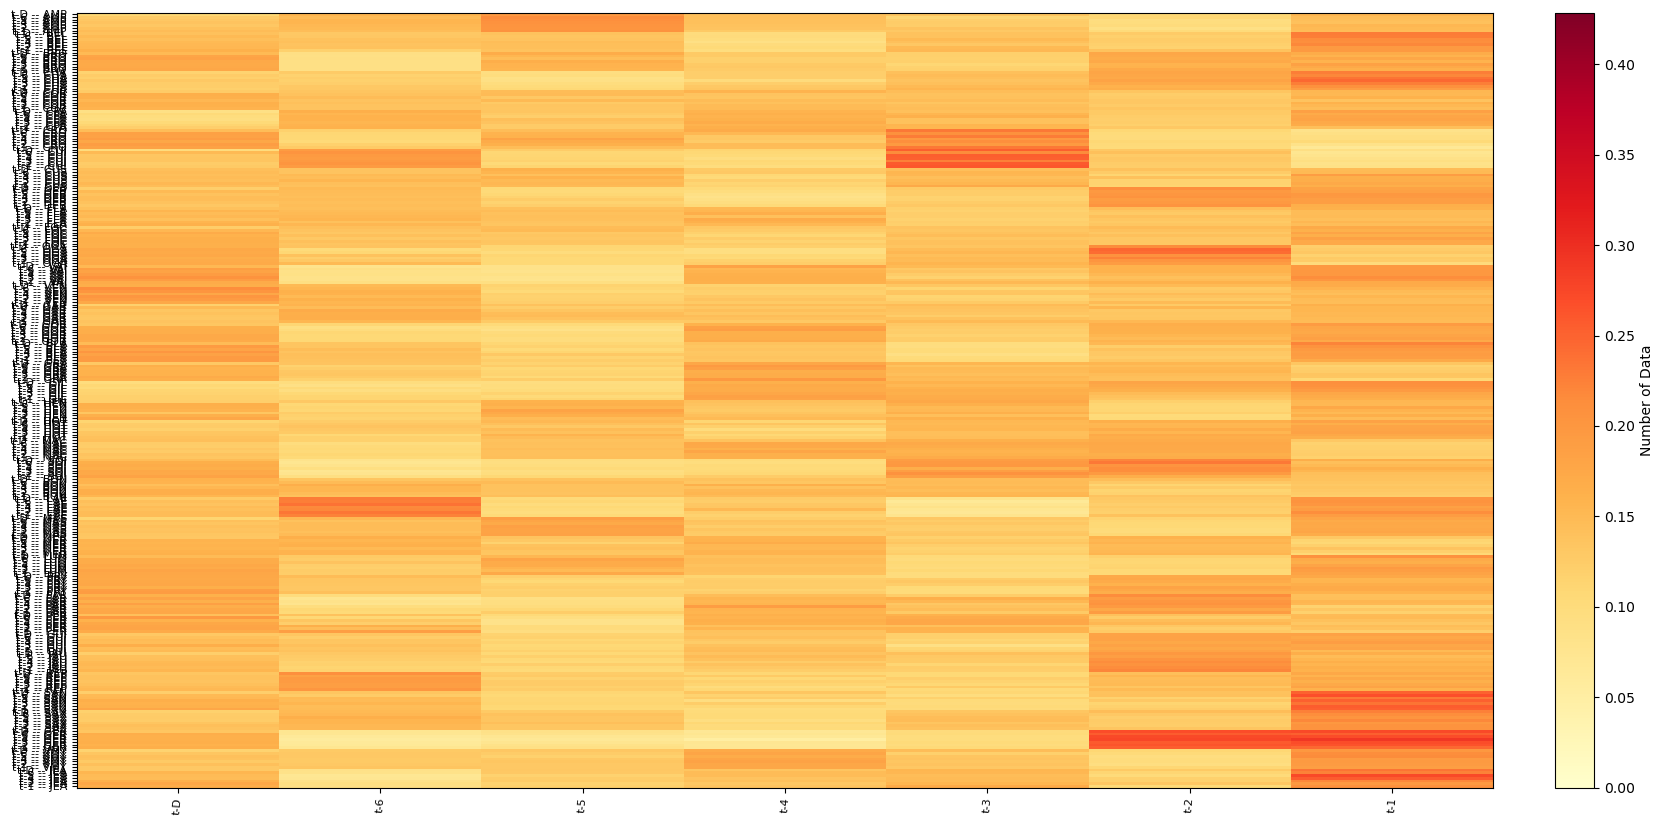

<Figure size 2000x1000 with 0 Axes>

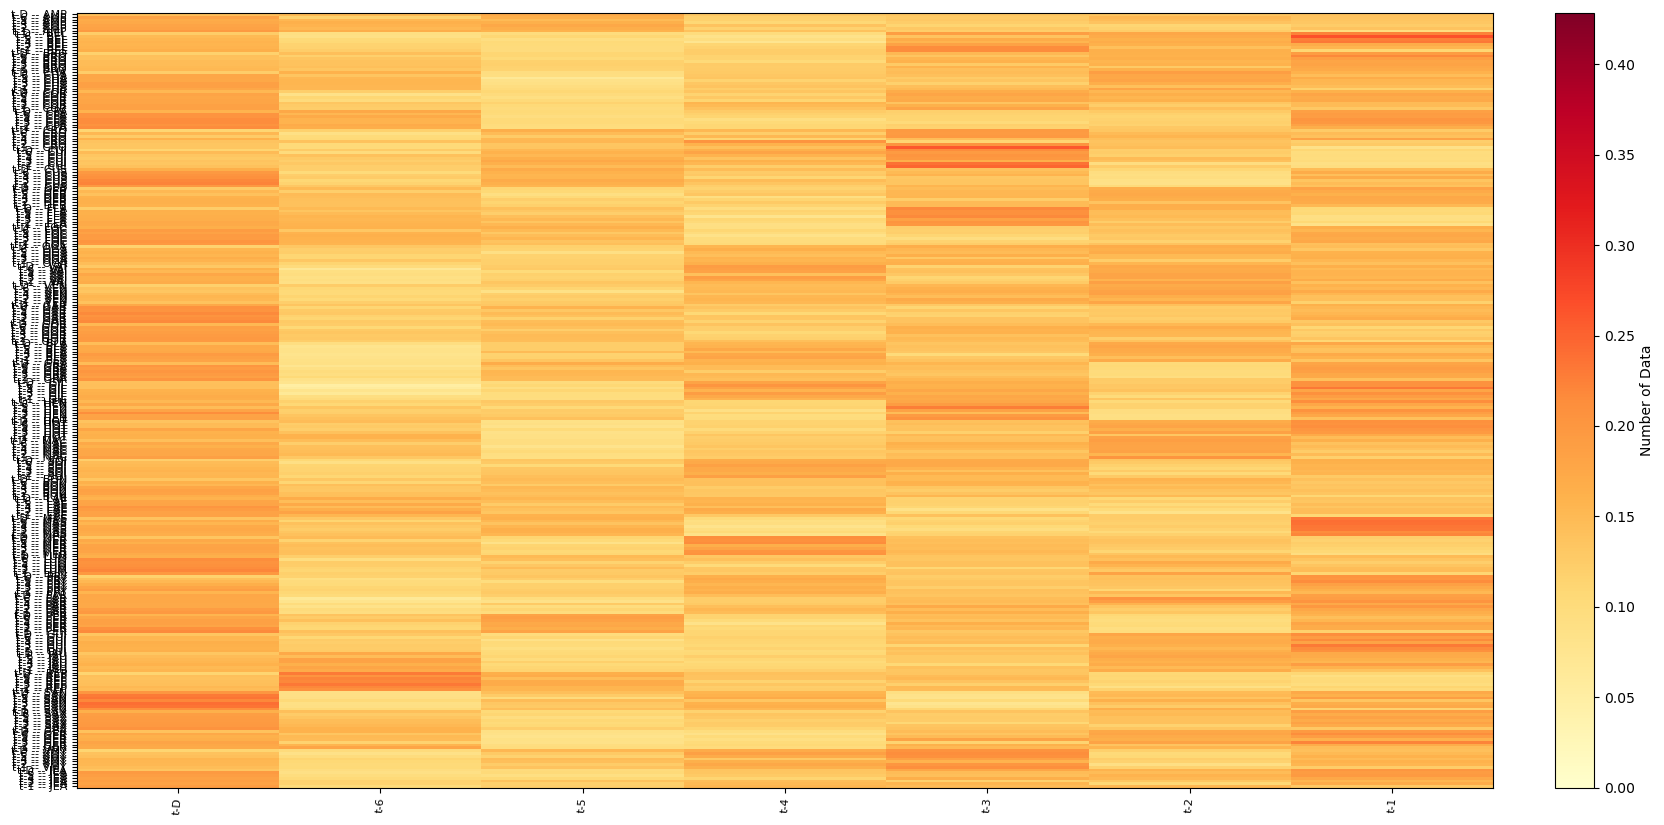

<Figure size 2000x1000 with 0 Axes>

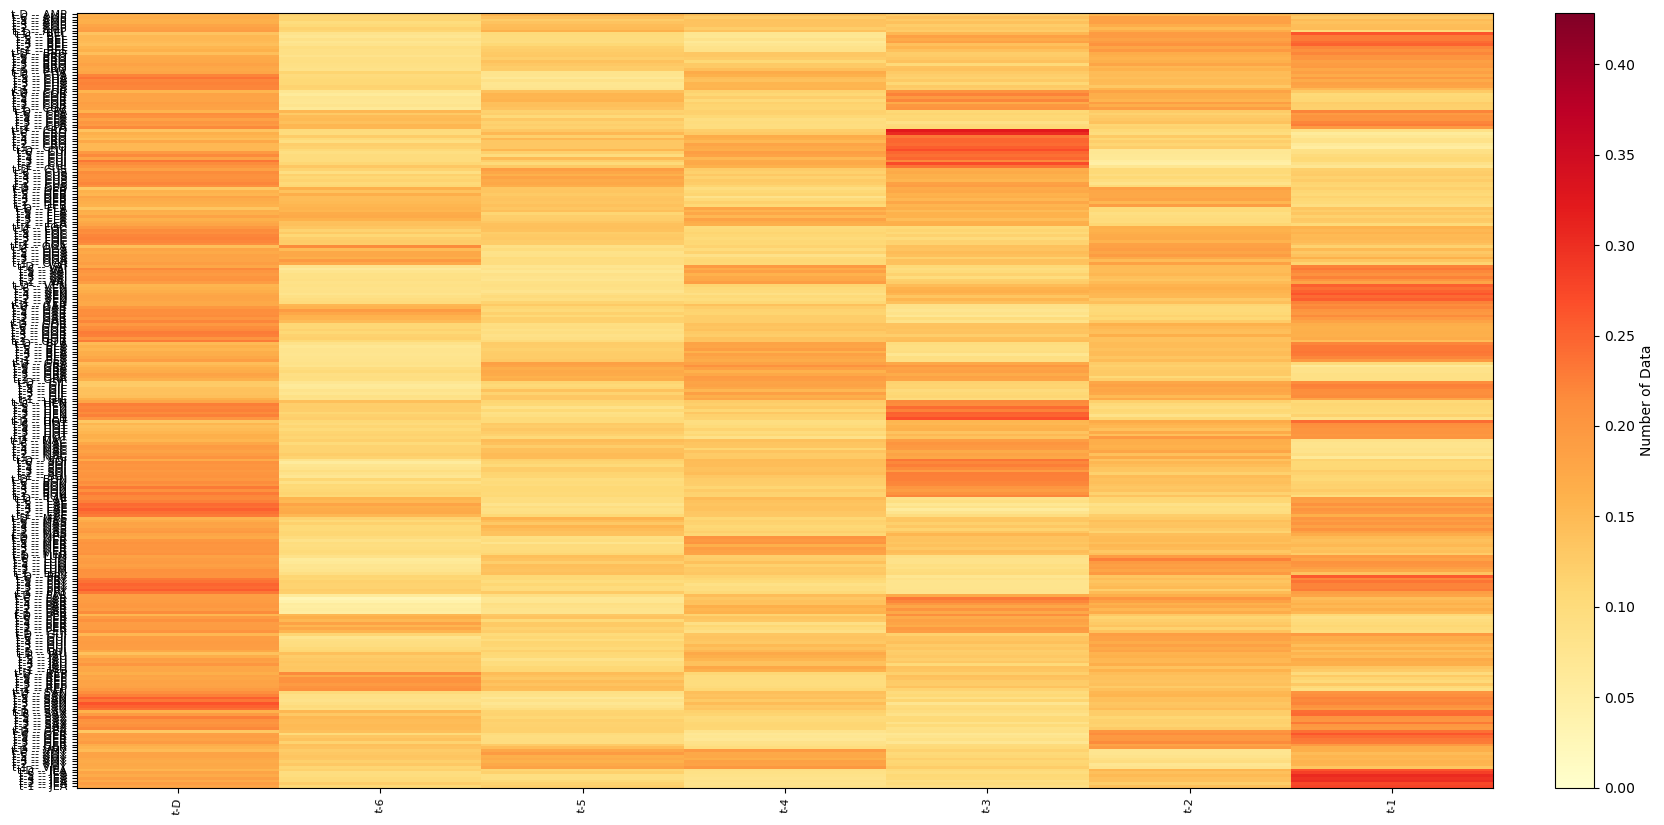

In [5]:
columns = ['t-D','t-6','t-5','t-4','t-3','t-2','t-1']

for temporal_layer in range(len(trainer.model._orig_mod.core_model.attn_layers_t)):
  attn_score = trainer.model._orig_mod.core_model.attn_layers_t[temporal_layer].attn.attn_score.detach().cpu()     # attn_score.size : torch.Size([19956, 40, 7, 7]) - - [B,N,L,L] 
  mean_attn_score = attn_score.mean(0)                                                                             #  mean_attn_score.size(): [40, 7, 7]             - -   [N,L,L]
  df_attn_weight = pd.DataFrame(mean_attn_score.reshape(-1,mean_attn_score.shape[-1]).numpy(),columns=columns,index=[f"{hist} -- {station_name}"   for station_name in ds.spatial_unit for hist in columns] )
  figsize=(20,10)
  matfig = plt.figure(figsize=figsize)
  plot_coverage_matshow(df_attn_weight, cmap ="YlOrRd", save = None, cbar_label =  "Number of Data",bool_reversed=False,
                          v_min=0,v_max=3*(1/df_attn_weight.shape[1]),
                          #   display_values = False,
                            bool_plot = True,
                            cbar_magic_args = True,
                            figsize = figsize
  )

## Attn-Score on Spatial-Attn Layer

<Figure size 2000x1000 with 0 Axes>

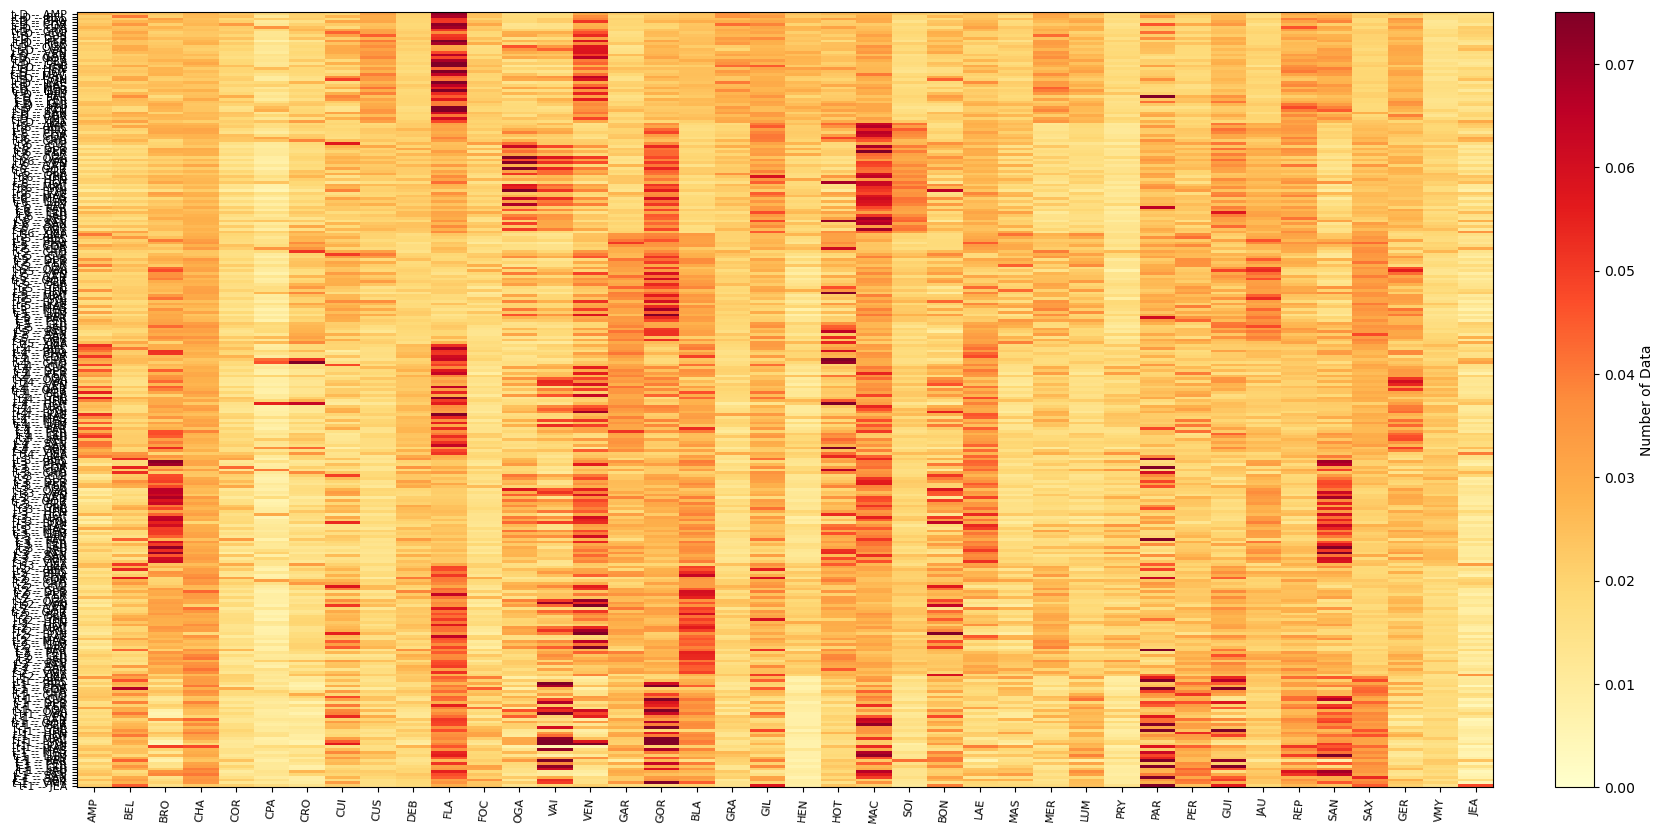

<Figure size 2000x1000 with 0 Axes>

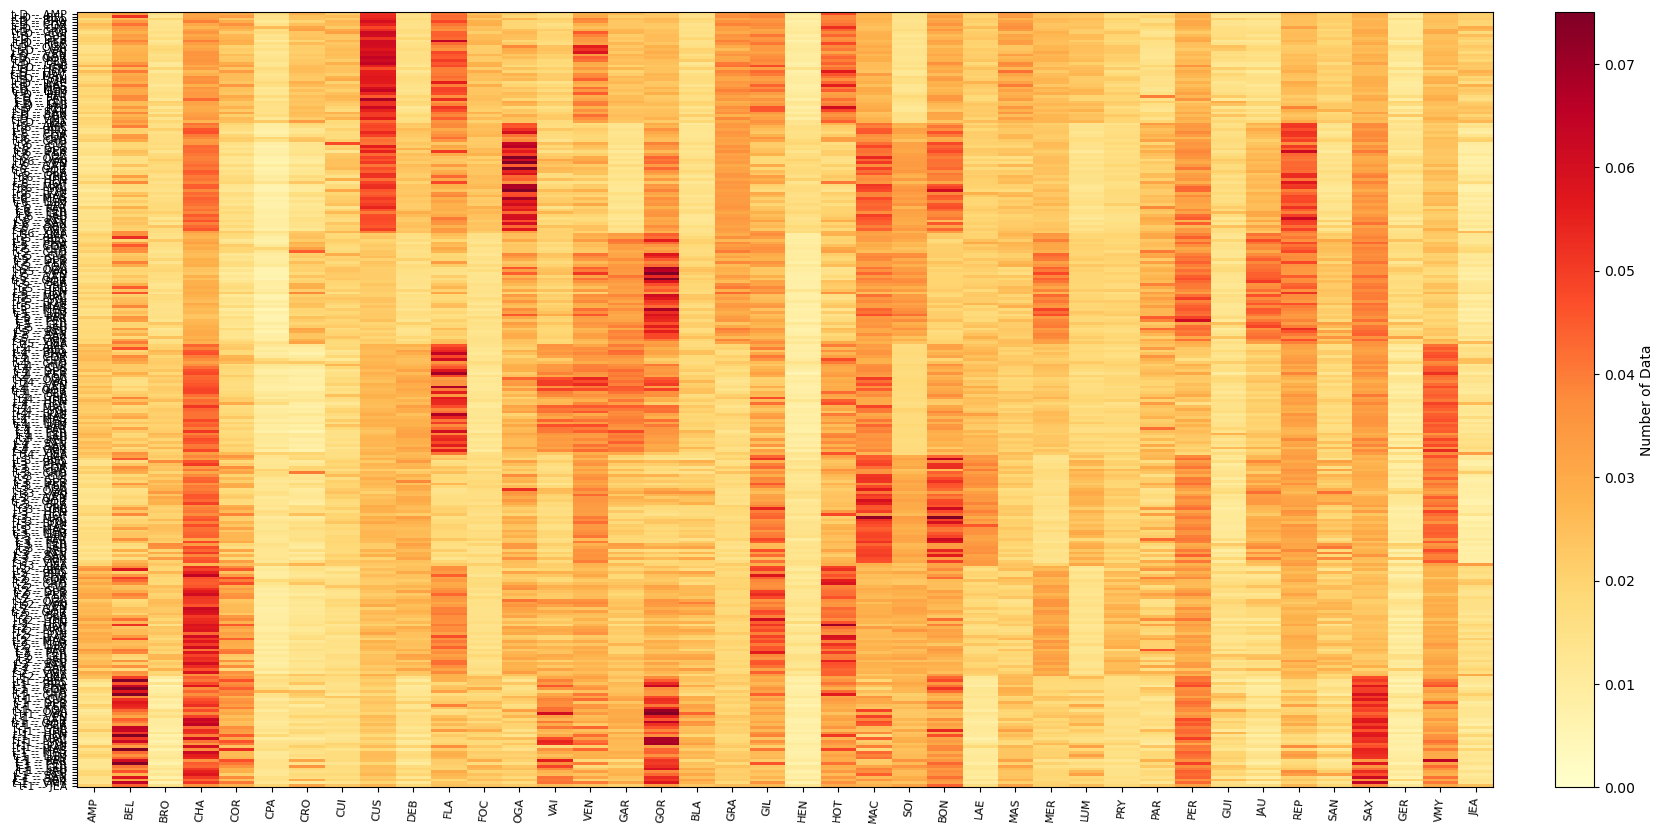

<Figure size 2000x1000 with 0 Axes>

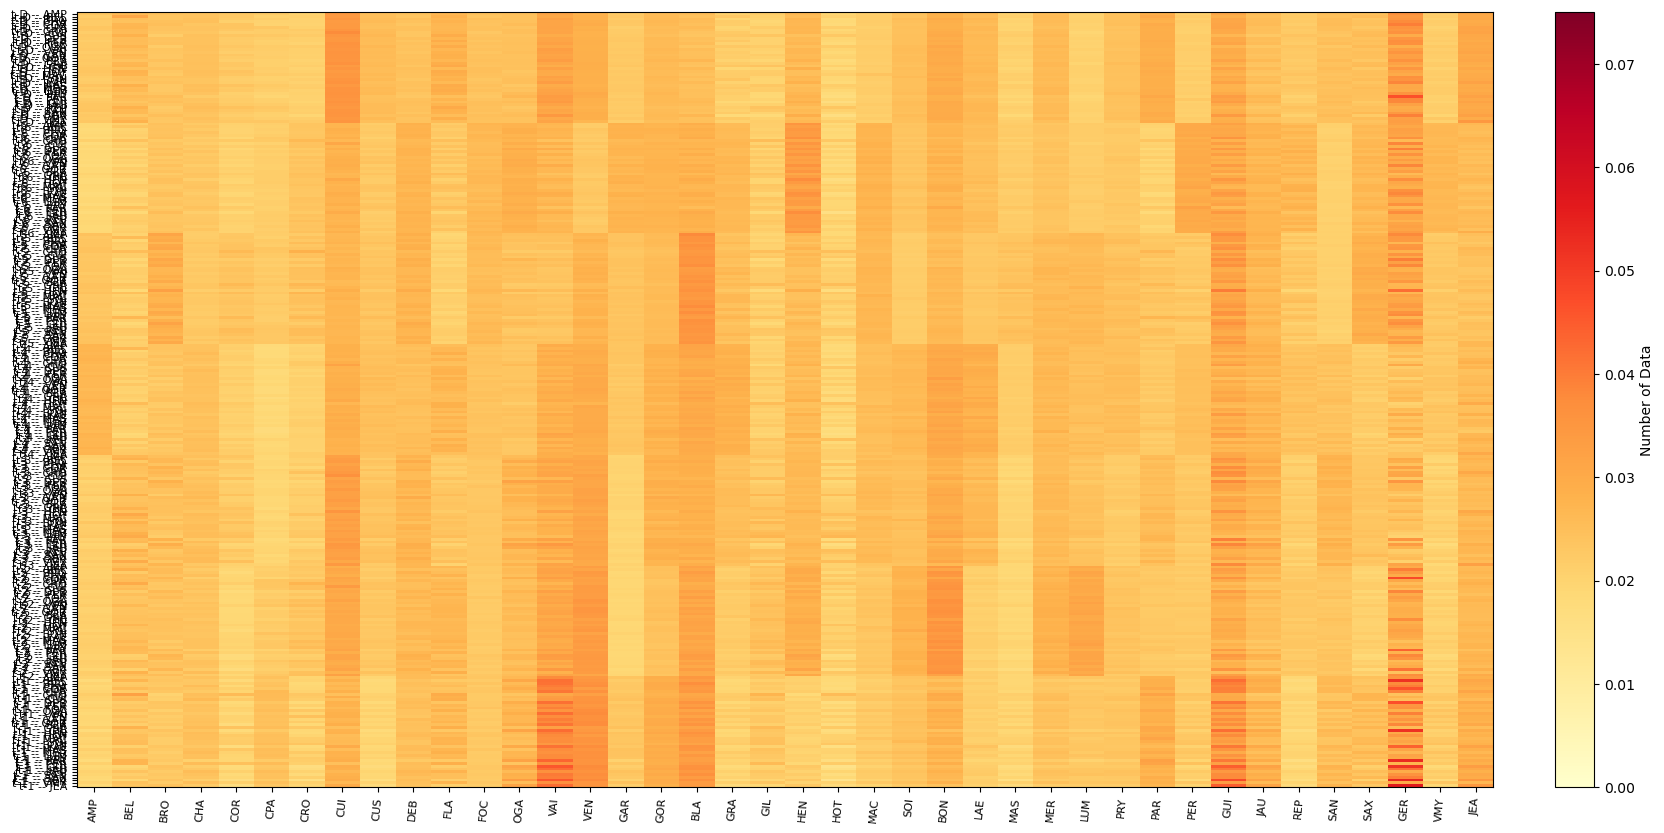

In [6]:

t_columns = ['t-D','t-6','t-5','t-4','t-3','t-2','t-1']

for temporal_layer in range(len(trainer.model._orig_mod.core_model.attn_layers_s)):
  attn_score = trainer.model._orig_mod.core_model.attn_layers_s[temporal_layer].attn.attn_score.detach().cpu()
  mean_attn_score = attn_score.mean(0)
  df_attn_weight = pd.DataFrame(mean_attn_score.reshape(-1,mean_attn_score.shape[-1]).numpy(),columns=ds.spatial_unit,index=[f"{hist} -- {station_name}"   for hist in t_columns  for station_name in ds.spatial_unit] )
  figsize=(20,10)
  matfig = plt.figure(figsize=figsize)
  plot_coverage_matshow(df_attn_weight, cmap ="YlOrRd", save = None, cbar_label =  "Number of Data",bool_reversed=False,
                           v_min=0,v_max=3*(1/df_attn_weight.shape[1]),
                          #   display_values = False,
                            bool_plot = True,
                            cbar_magic_args = True,
                            figsize = figsize
  )

## Analysis on Attention Weights related to Contextual Data :

----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 35040 elts between 2019-01-01 00:00:00 and 2019-12-31 23:45:00
Invalid dates within this fold: 1233

>>>Tackle Target dataset: subway_out
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_out/subway_out.csv
   Init Dataset: 'torch.Size([35040, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([14962, 40, 7])
   VALID contextual_ds: torch.Size([4987, 40, 7])
   TEST contextual_ds: torch.Size([4987, 40, 7])

>>>Loading calendar inputs ...

>>>Tackle Contextual dataset:  bike_in
Loading from /home/rrochas/../../data/rrochas/prediction_validation/agg_data/velov/velov_attracted_by_station15min.csv...
df pivoted:  (70094, 435)
df reindexed :  (35040, 435)
Len coverage period:  35040
df filtered:  (35040, 435)
   Loaded data: (35040, 435)
   Dimension after spatial agg: (35040, 26)

>>>Tackle Contextual dataset:  subway_in
   Load data from: //home/rr

<Figure size 2000x1000 with 0 Axes>

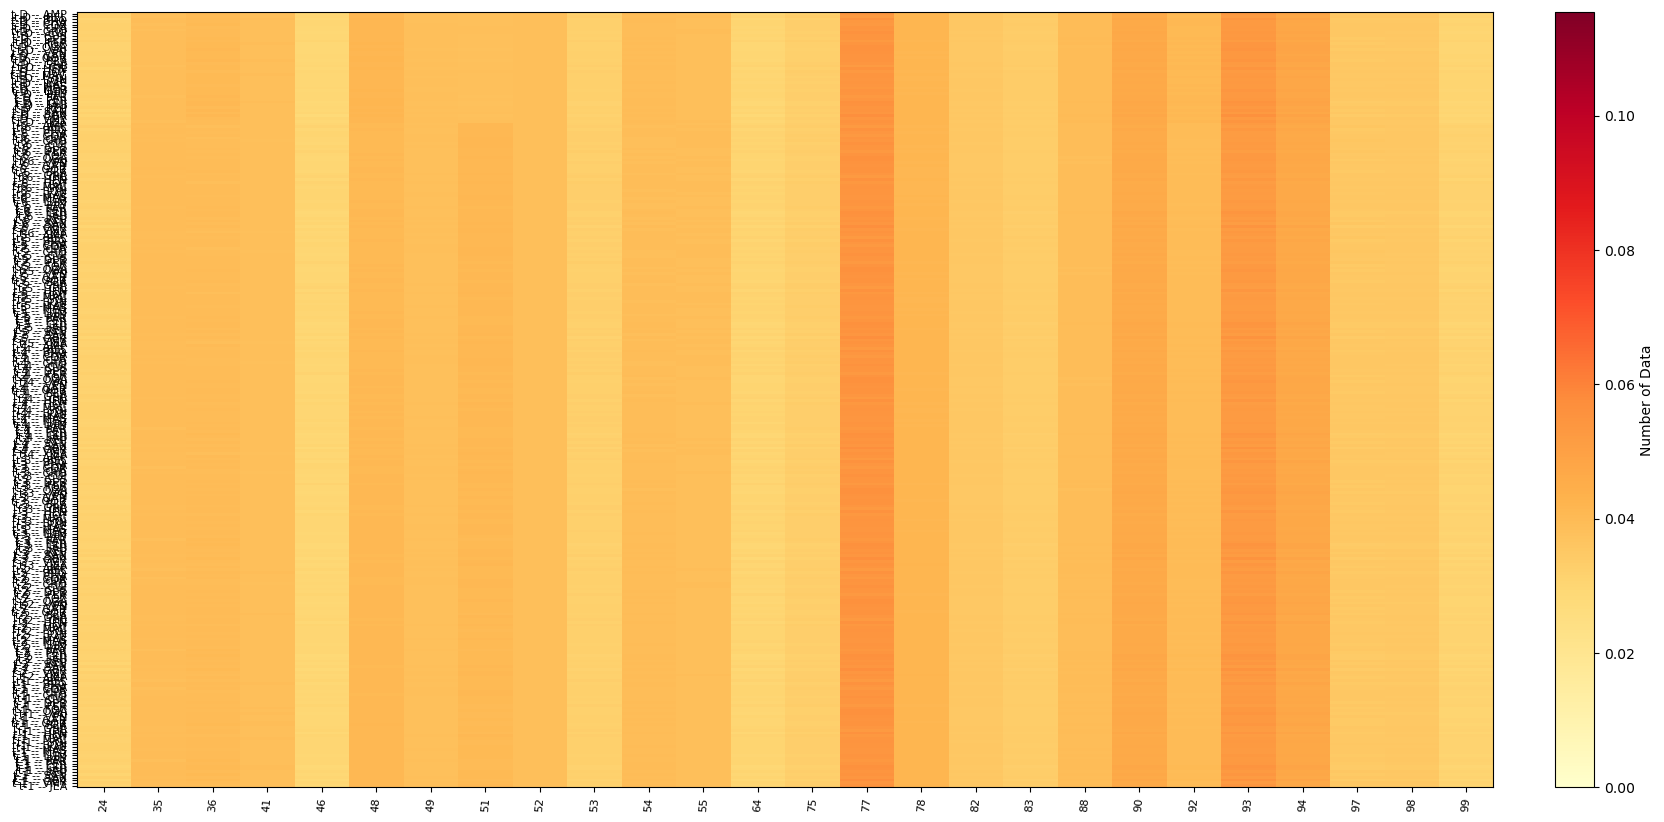

<Figure size 2000x1000 with 0 Axes>

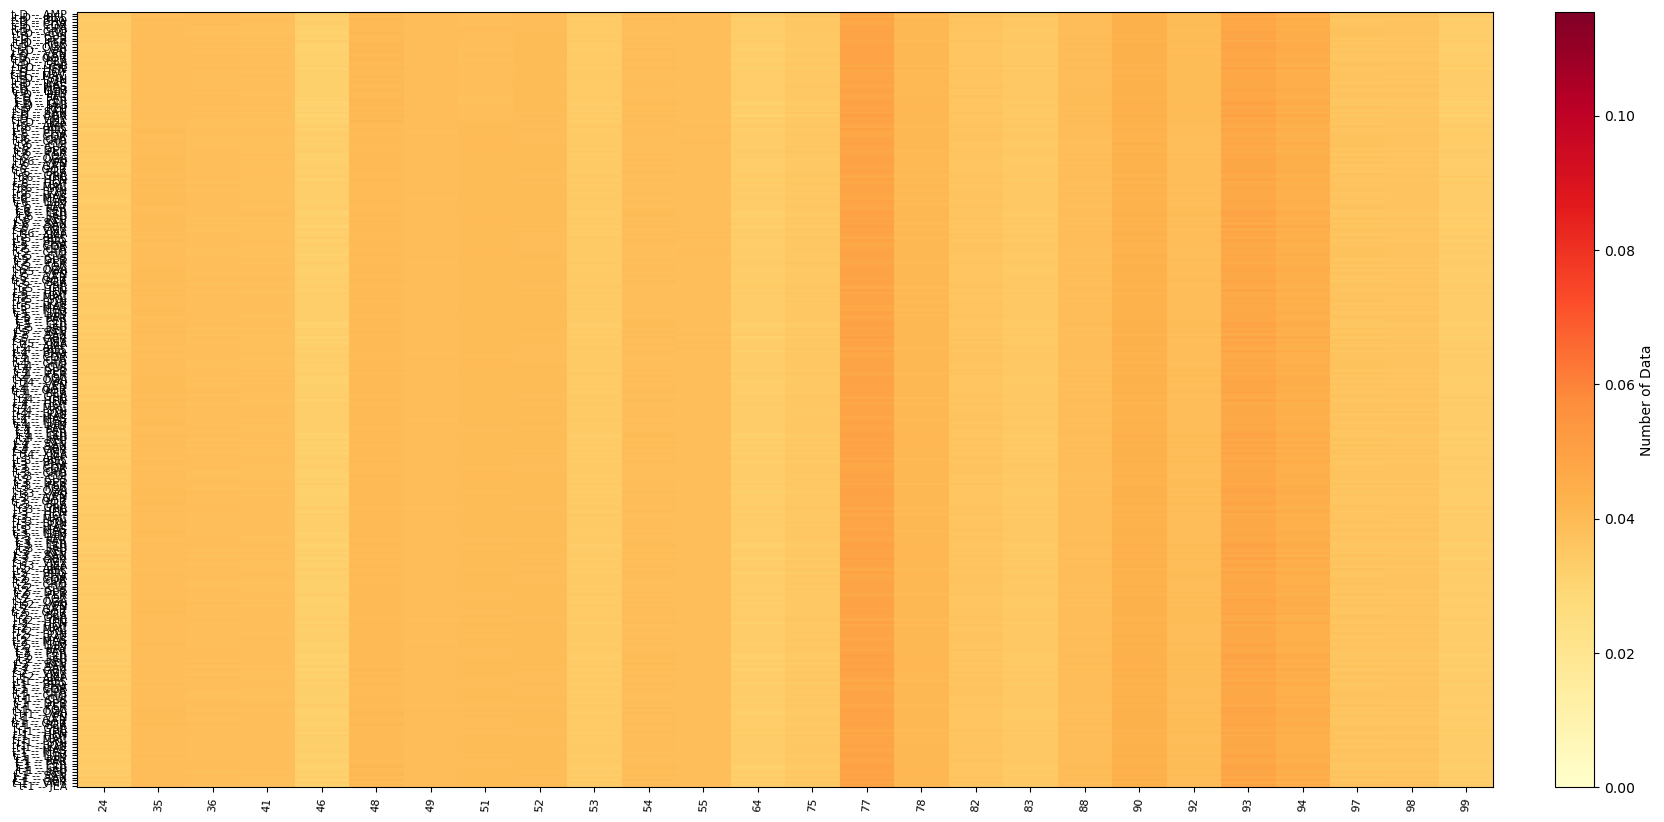

<Figure size 2000x1000 with 0 Axes>

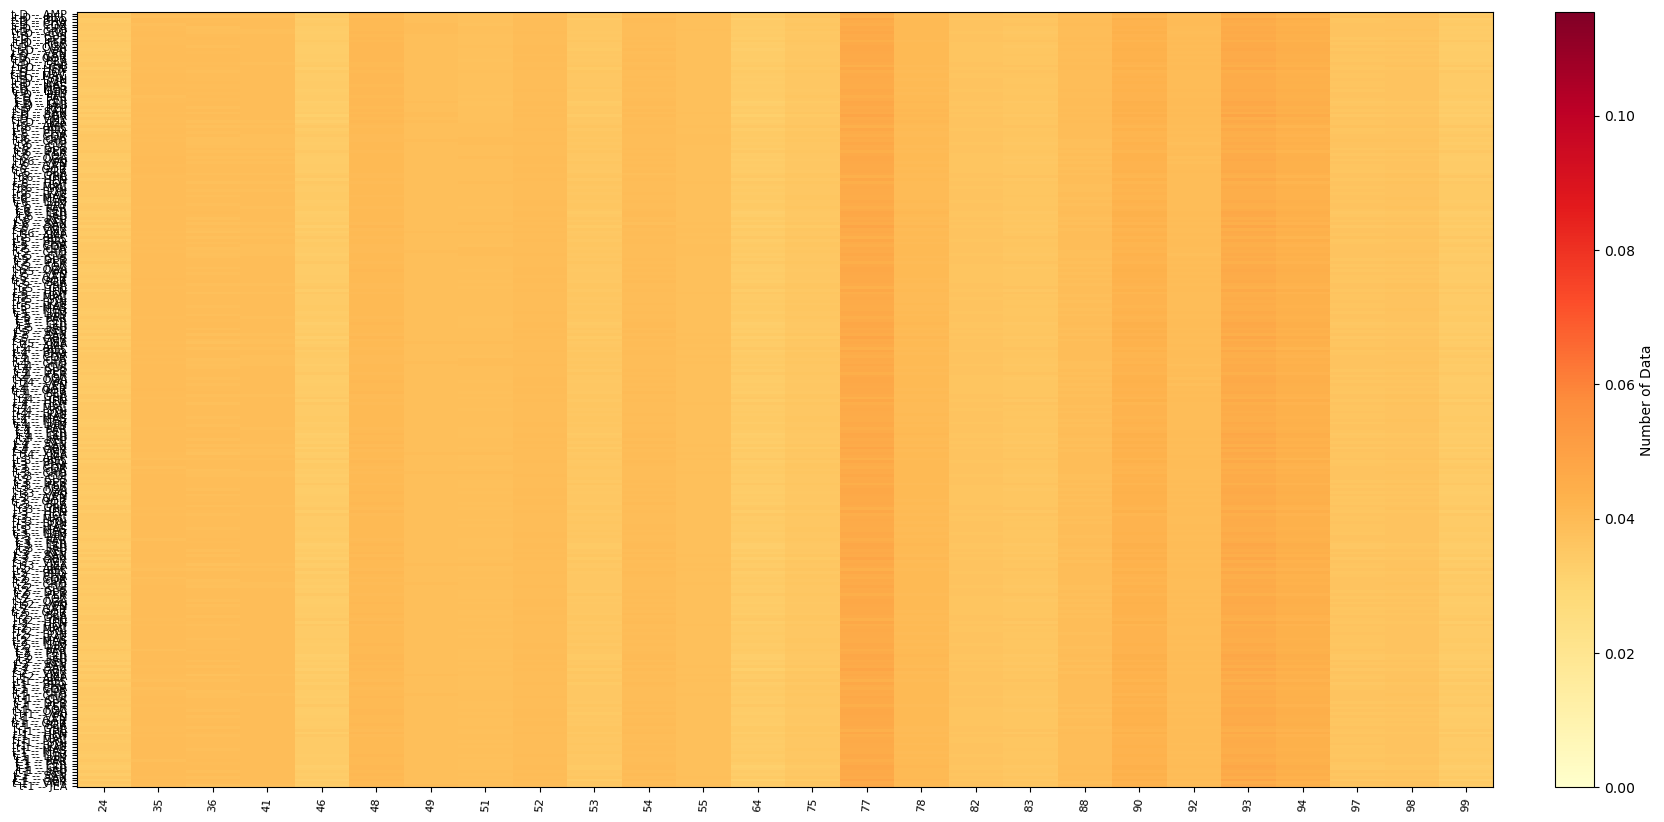

<Figure size 2000x1000 with 0 Axes>

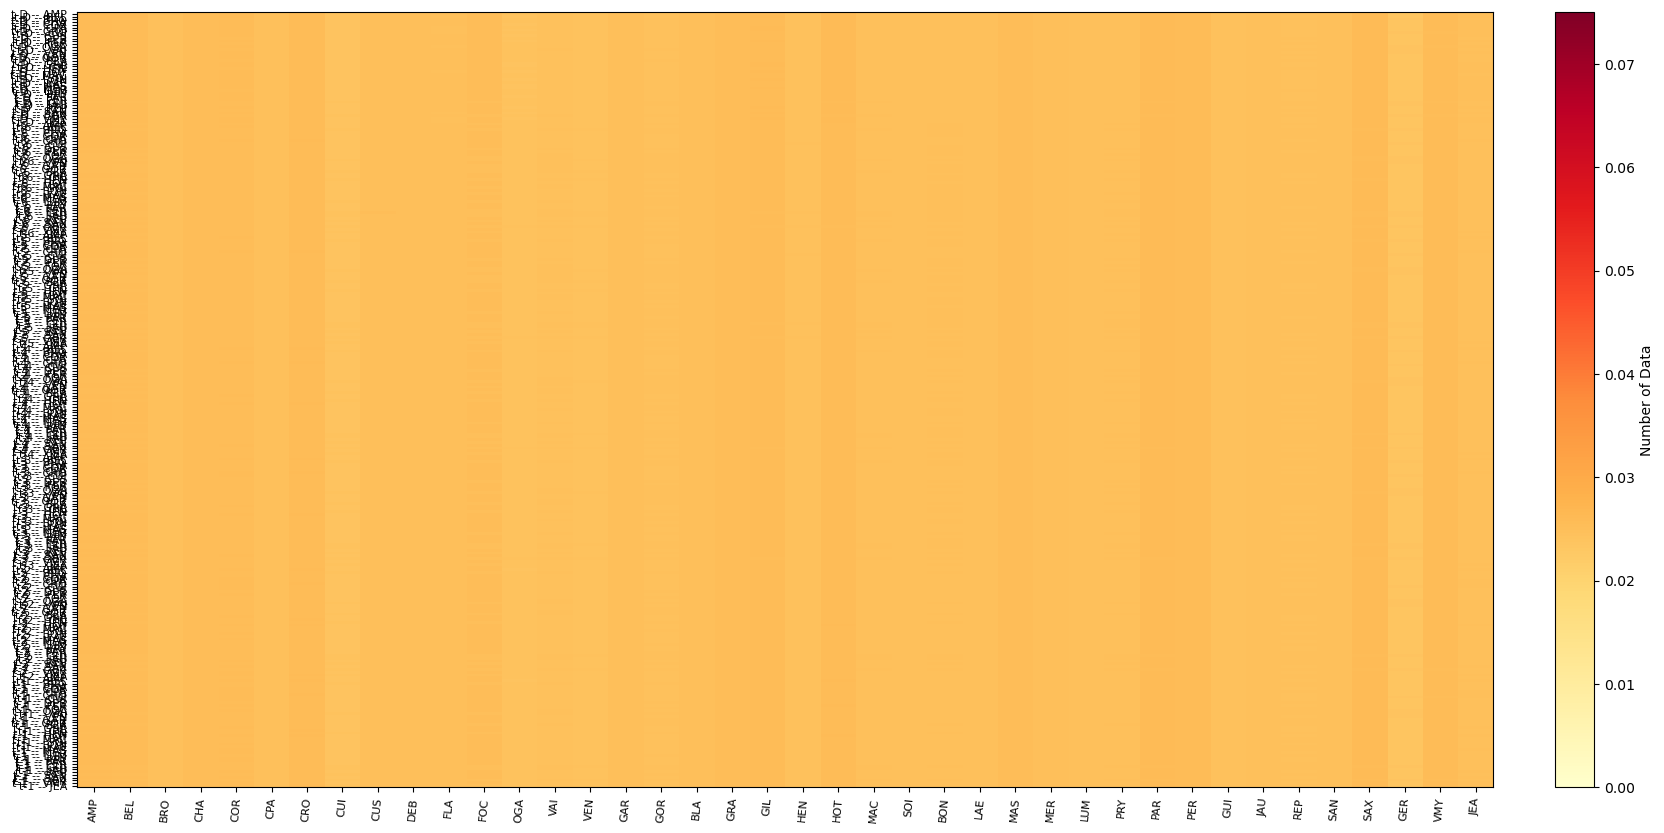

<Figure size 2000x1000 with 0 Axes>

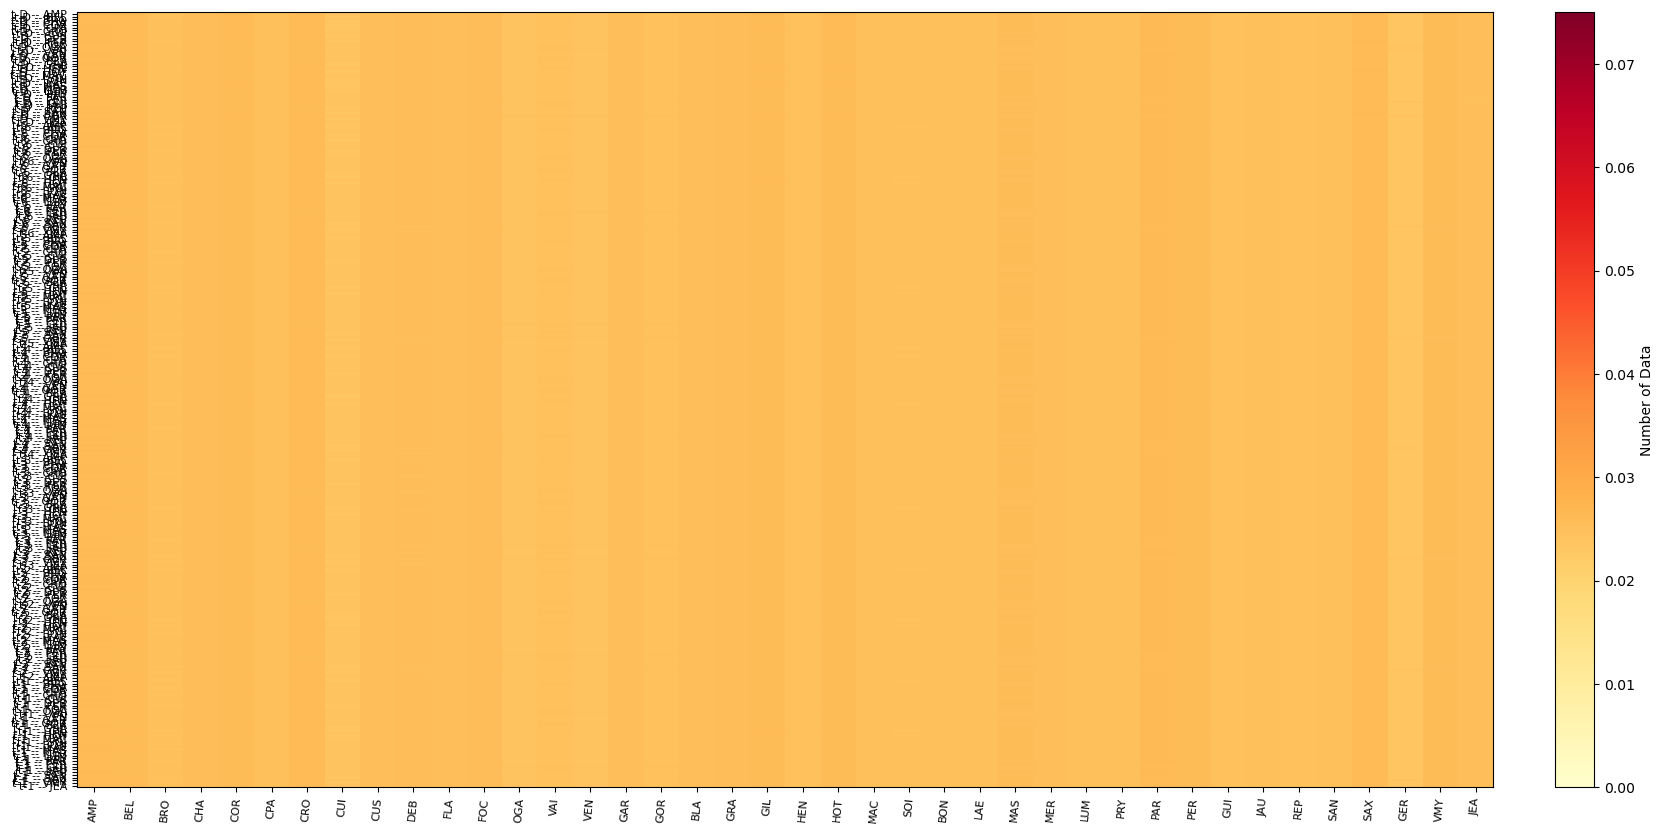

<Figure size 2000x1000 with 0 Axes>

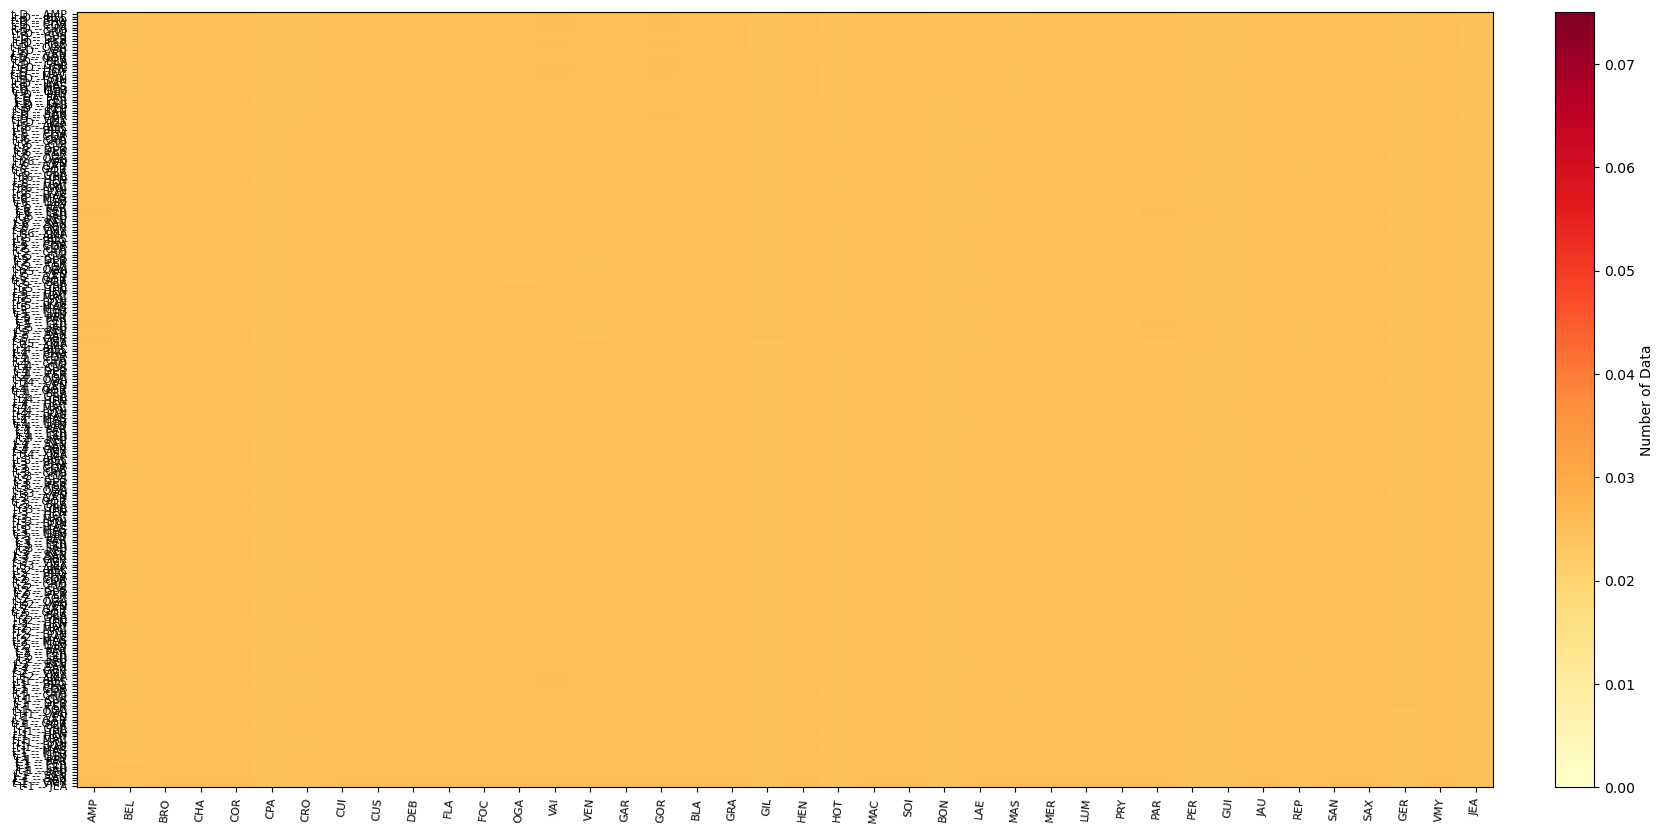

In [11]:
subfolder = 'best_models'
target_data = 'subway_out' # subway_out # bike_out
model_name = 'STAEformer'
horizon = 4
if False:
  trial_id = 'bike_out_subway_out_calendar_AttnKeepTempDimH4L3D128FF256_Agg100_Freq1H_e100_h1_bis1'  
  trial_id = 'bike_out_subway_in_calendar_AttnKeepTempDimH4L3D128FF256_Agg100_Freq1H_e100_h1_bis1'
if False:
  ds_name = 'subway_out' #  'subway_in' # 'subway_out'
  trial_id = f'bike_out_{ds_name}_calendar_CalendarAttnSTAEformerH4L3D24FF128_Agg100_Freq1H_e100_h1_bis1'

if True:
  ds_name = ['bike_in','subway_in']# ['bike_in','bike_out','subway_in'] #  'subway_in' # 'subway_out'
  trial_id = f"subway_out_{'_'.join(ds_name)}_calendar_CalendarAttnSTAEformerH4L3D24FF128_e100_h{horizon}_bis1"
model_id = f"{trial_id}_f5"     # One trial_id can be associated to several folds 

model_args = pickle.load(open(f"{working_dir}/{target_data}_{model_name}/{subfolder}/model_args.pkl",'rb'))
model_save_path = f"{working_dir}/{target_data}_{model_name}/{subfolder}/{model_id}.pkl"

args_bike_out = model_args['model'][model_id]['args']
args_bike_out = Namespace(**args_bike_out)

trainer_bike_out, ds_bike_out, args_init_bike_out = load_trainer_ds_from_saved_trial(args_bike_out,model_save_path,
                                                          modification = {'shuffle':False,
                                                                           'data_augmentation':False ,
                                                                           'torch_compile':False})

## --- Plot time-series prediction and get inputs 
if False: 
  training_mode = 'test'
  station = [ds_bike_out.spatial_unit[0]]
  Preds,Y_true,T_labels = trainer_bike_out.testing(ds_bike_out.normalizer, training_mode =training_mode)   
  df_true,df_predictions = get_df_for_visualisation(ds_bike_out,Preds,Y_true,training_mode,trainer_bike_out.out_dim_factor,stations=station)
  visualisation_special_event(trainer_bike_out,df_true,df_predictions,station=station,min_flow=0)

  print('MAE: ',torch.abs(Y_true-Preds).mean().item(),'\n',
        'RMSE: ', np.sqrt(((Y_true-Preds)**2).mean().item()),'\n',
        'MSE: ', ((Y_true-Preds)**2).mean().item(),'\n'
  )

all_data = [tensors for tensors in zip(*trainer_bike_out.dataloader['test'])]

X = torch.cat(all_data[0]).to(args_init_bike_out.device)
Y = torch.cat(all_data[1]).to(args_init_bike_out.device)
Xc = [torch.cat(context_tensors).to(args_init_bike_out.device) for context_tensors in zip(*all_data[2])]

model = trainer_bike_out.model
model.eval()
with torch.no_grad():
    pred = model(X, Xc)
# ---

## --- Analyse Attention Weights on Temporal dim (of the temporal-attention-layers of the STAEformer): 
if False:
  columns = ['t-D','t-6','t-5','t-4','t-3','t-2','t-1']
  for temporal_layer in range(len(trainer_bike_out.model.core_model.attn_layers_t)):
    attn_score_bike_out = trainer_bike_out.model.core_model.attn_layers_t[temporal_layer].attn.attn_score.detach().cpu()
    mean_attn_score_bike_out = attn_score_bike_out.mean(0)
    df_attn_weight_bike_out = pd.DataFrame(mean_attn_score_bike_out.reshape(-1,mean_attn_score_bike_out.shape[-1]).numpy(),columns=columns,index=[f"{hist} -- {station_name}"   for station_name in ds_bike_out.spatial_unit for hist in columns] )
    figsize=(20,10)
    matfig = plt.figure(figsize=figsize)
    plot_coverage_matshow(df_attn_weight_bike_out, cmap ="YlOrRd", save = None, cbar_label =  "Number of Data",bool_reversed=False,
                          v_min=0,v_max=3*(1/df_attn_weight_bike_out.shape[1]),
                            #   display_values = False,
                              bool_plot = True,
                              cbar_magic_args = True,
                              figsize = figsize,
    )
  # ---

for ds_name_i in ds_name:
  print(ds_name_i)
  # --- Analysis of ST-Attention Weights associated to the contextual datasets: ---
  for mha_layer in range(len(trainer_bike_out.model.global_s_attn[f'{ds_name_i}'].attn_layers)):
    attn_score_bike_out = trainer_bike_out.model.global_s_attn[f'{ds_name_i}'].attn_layers[mha_layer].attn.attn_score.detach().cpu()
    mean_attn_score_bike_out = attn_score_bike_out.mean(0)
    df_attn_weight_bike_out = pd.DataFrame(mean_attn_score_bike_out.reshape(-1,mean_attn_score_bike_out.size(-1)).numpy(),
                                columns = args_bike_out.contextual_kwargs[ds_name_i]['spatial_unit'],
                                index =[f"{hist} -- {bike_station}"   for hist in columns for bike_station in ds_bike_out.spatial_unit] )
    figsize=(20,10)
    matfig = plt.figure(figsize=figsize)
    plot_coverage_matshow(df_attn_weight_bike_out, cmap ="YlOrRd", save = None, cbar_label =  "Number of Data",bool_reversed=False,
                            v_min=0,v_max=3*(1/df_attn_weight_bike_out.shape[1]),
                            #   display_values = False,
                              bool_plot = True,
                              cbar_magic_args = True,
                              figsize = figsize,
    )
# ---